# Decode stimuli from neural activity - Templeton

In [2]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import glob
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

%matplotlib notebook

In [3]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-26_14-09-36_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-27_13-57-17_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-08-02_15-40-19_620264\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-17_11-39-17_646318\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-18_10-44-55_646318\processed",
]

modality = ['vis','vis','aud','vis','aud','aud','vis','vis','aud','aud']
mouseIDs = ['620263','620263','620264','628801','636397','636397','644547','644547','646318','646318']
exp_nums = [1,2, 1, 1, 1,2, 1,2, 1,2]

## Load a single session

In [70]:
sel_session=2
session=Session(path=main_path[sel_session]) 
session.assign_unit_areas()

probeA areas found
probeB areas found
probeC areas found
probeF areas found


In [ ]:
# trials table
session.trials

In [ ]:
# units table
session.good_units

In [71]:
session.good_units['area'].value_counts()

MOs5            60
ORBvl5          50
ORBvl6a         44
ORBl6a          35
SSp-tr5         32
AUDd6a          27
SSs5            27
VISp5           27
POST            20
FRP6a           15
SSp-tr6a        13
VISp6a          13
SSs4            12
AUDd5           11
VISp4           10
OLF              8
SUB              8
SSs2/3           5
CP               5
MOs2/3           5
VISp2/3          5
N/A              5
ORBl5            3
AUDd6b           2
HPF              2
out of brain     2
SSp-tr2/3        2
SSp-tr4          2
VISp6b           1
CA1              1
Name: area, dtype: int64

In [ ]:
# spike times from one unit
session.spike_times[session.units.index[0]]

In [ ]:
# information about each frame
session.frames

In [72]:
# loop through sessions and make unit xarrays
time_before_flash = 0.5
trial_duration = 2
bin_size = 0.001


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              session.trials,time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": session.trials.index.values
                               })

### decode by area

In [73]:
#shorten the area names to better lump together units
#get rid of layers and/or sub-areas with dashes
area_short = []
for area in session.good_units['area']:
    if area=='N/A':
        short='N/A'
    elif area[:2]=='CA':
        short=area
    else:
        dig_ind=re.search(r"\d", area)
        dash_ind=re.search(r"-", area)
        if dig_ind!=None:
            short=area[:dig_ind.start()]
        elif dash_ind!=None:
            short=area[:dash_ind.start()]
        else:
            short=area
        
    area_short.append(short)
    
session.good_units['area_short']=area_short

In [74]:
area_counts=session.good_units['area_short'].value_counts()
area_counts[area_counts>25].index

Index(['ORBvl', 'MOs', 'VISp', 'SSp-tr', 'SSs', 'AUDd', 'ORBl'], dtype='object')

In [ ]:
#try more timepoints & split by areas

svc_results={}
binsize=0.25

# grab data: make these [trials,neurons] matrices based on different time bins:
# only include irrelevant stimuli?
if modality[sel_session]=='vis':
    trial_sel=session.trials.query('trialStimID.str.contains("sound")').index
    area_sel=['AUD']
elif modality[sel_session]=='aud':
    trial_sel=session.trials.query('trialStimID.str.contains("vis")').index
    area_sel=['VIS']
# area_sel = area_counts[area_counts>25].index

# grab the stimulus ids
stim_ids = np.vstack(session.trials['trialStimID'][trial_sel].values)

time_bins=np.arange(-0.25,0.6,binsize)

for aa in area_sel:
    unit_sel = session.good_units.query('area.str.contains(@aa)').index.values
    svc_results[aa]={}
    for tt,t_start in enumerate(time_bins[:-1]):
        
        sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                        trials=trial_sel,unit_id=unit_sel).mean(dim='time').values
        
#     for tt,t_end in enumerate(time_bins[1:]):
        
#         sel_data = session.trial_da.sel(time=slice(time_bins[0],t_end),
#                                         trials=trial_sel,unit_id=unit_sel).mean(dim='time').values
        
        X = sel_data.T
        y = stim_ids

        xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)

        clf = svm.LinearSVC()
        clf.fit(xtrain, ytrain)

        ypred = clf.predict(xtest)

        cr_dict=classification_report(ytest, ypred, output_dict=True)
        cr_df=pd.DataFrame.from_dict(cr_dict)

        svc_results[aa][tt]=cr_df
        
        


In [ ]:
# unit_sel


In [ ]:
# session.trials.query('trialStimID.str.contains("sound")')
# plot_results

In [ ]:
# make into more plottable format

plot_results={}

timepoints=time_bins[1:]

areas=area_sel

for aa in areas:
    plot_results[aa]={}
#     plot_results[tt]['modality']=modality
    plot_results[aa]['vis']=[]
    plot_results[aa]['aud']=[]
#     for tt,tp in enumerate(timepoints):
#         plot_results[aa][tt]=[]
        

         
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

for aa in areas: #svc_results[ss]['results'].keys():
    if aa in svc_results.keys():
        for tt,tp in enumerate(timepoints):
            
            if modality[sel_session]=='aud':
                vis_perf=(
                    np.sum([svc_results[aa][tt]['vis1'][['precision','recall']].values,
                            svc_results[aa][tt]['vis2'][['precision','recall']].values]))/4
                plot_results[aa]['vis'].append(vis_perf)
            
            elif modality[sel_session]=='vis':
                aud_perf=(
                    np.sum([svc_results[aa][tt]['sound1'][['precision','recall']].values,
                            svc_results[aa][tt]['sound2'][['precision','recall']].values]))/4
                plot_results[aa]['aud'].append(aud_perf)


#     plot_results[tt]=pd.DataFrame.from_dict(plot_results[tt])

In [ ]:
fig,ax=plt.subplots(len(plot_results.keys()),1,figsize=(8,4))

if type(ax)!=np.ndarray:
    ax=[ax]

for aa,area in enumerate(plot_results.keys()):
    if modality[sel_session]=='aud':
        ax[aa].plot(timepoints,plot_results[area]['vis'])
    elif modality[sel_session]=='vis':
        ax[aa].plot(timepoints,plot_results[area]['aud'])
    
    ax[aa].set_ylim([-0.1,1.1])
    ax[aa].axvline(0,color='k')
#     ax[aa].axhline(0.25,color='k',linewidth=0.5,linestyle='--')
    ax[aa].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[aa].set_title(area)
    if aa<len(plot_results.keys())-1:
        ax[aa].set_xticklabels('')

ax[aa].set_xlabel('time from stimulus onset (s)')
ax[aa].set_ylabel('decoder accuracy')

if modality[sel_session]=='aud':
    fig.suptitle('decoding irrelevant visual stimuli: '
                 +mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session]))
elif modality[sel_session]=='vis':
    fig.suptitle('decoding irrelevant auditory stimuli: '
                +mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session]))
    
fig.tight_layout()

In [ ]:
unit_sel.shape

## vary number of trials, specify n units

In [ ]:
#use varying numbers of trials

#sample with replacement ~100 times?

#try more timepoints & split by areas

svc_results={}
binsize=0.25

trial_number=[2,4,8,16,32,64]
n_repeats=100
n_units=50

# grab data: make these [trials,neurons] matrices based on different time bins:
# only include irrelevant stimuli?
if modality[sel_session]=='vis':
    trial_sel=session.trials.query('trialStimID.str.contains("sound")').index
    area_sel=['AUD']
elif modality[sel_session]=='aud':
    trial_sel=session.trials.query('trialStimID.str.contains("vis")').index
    area_sel=['VIS']
# area_sel = area_counts[area_counts>25].index

# grab the stimulus ids
stim_ids = np.vstack(session.trials['trialStimID'][trial_sel].values)

pred_var = stim_ids


time_bins=np.arange(-0.25,0.6,binsize)

for aa in area_sel:
    unit_sel = session.good_units.query('area.str.contains(@aa)').index.values
    svc_results[aa]={}
    
    for tridx,trnum in enumerate(trial_number):
        svc_results[aa][tridx]={}

        for tt,t_start in enumerate(time_bins[:-1]):
            
            svc_results[aa][tridx][tt]={}
            
            for nn in range(0,n_repeats):
                
                #choose n units
                unit_subset = np.random.choice(unit_sel,n_units,replace=True)
                
                ### make sure equal # of trials per condition!
                subset_ind=[]
                conds = np.unique(pred_var)
                for cc in conds:
                    cond_inds=np.where(pred_var==cc)[0]
                    subset_ind.append(np.random.choice(cond_inds,trnum,replace=True))   
                subset_ind=np.sort(np.hstack(subset_ind))
                
                sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                                trials=trial_sel[subset_ind],
                                                unit_id=unit_subset).mean(dim='time').values

        #     for tt,t_end in enumerate(time_bins[1:]):

        #         sel_data = session.trial_da.sel(time=slice(time_bins[0],t_end),
        #                                         trials=trial_sel,unit_id=unit_sel).mean(dim='time').values

                X = sel_data.T
                y = pred_var[subset_ind]

                xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, stratify=y)

                clf = svm.LinearSVC()
                clf.fit(xtrain, ytrain)

                ypred = clf.predict(xtest)

                cr_dict=classification_report(ytest, ypred, output_dict=True)
                cr_df=pd.DataFrame.from_dict(cr_dict)

                svc_results[aa][tridx][tt][nn]=cr_df
        
        

In [ ]:
# svc_results[area][n_trials][time_point][re-run]
# ytrain

In [ ]:
# make into more plottable format

####change this to deal with multiple #s of trials and average over re-runs of the SVC

plot_results={}

timepoints=time_bins[1:]

areas=area_sel

for aa in areas:
    plot_results[aa]={}
    for tridx,trnum in enumerate(trial_number):
    #     plot_results[tt]['modality']=modality
        plot_results[aa][tridx]={}
        plot_results[aa][tridx]['vis1']=np.zeros((len(time_bins[:-1]),n_repeats))
        plot_results[aa][tridx]['vis2']=np.zeros((len(time_bins[:-1]),n_repeats))
        plot_results[aa][tridx]['aud1']=np.zeros((len(time_bins[:-1]),n_repeats))
        plot_results[aa][tridx]['aud2']=np.zeros((len(time_bins[:-1]),n_repeats))

        plot_results[aa][tridx]['True']=np.zeros((len(time_bins[:-1]),n_repeats))
        plot_results[aa][tridx]['False']=np.zeros((len(time_bins[:-1]),n_repeats))
    #     for tt,tp in enumerate(timepoints):
    #         plot_results[aa][tt]=[]
        

         
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

for aa in areas: #svc_results[ss]['results'].keys():
    if aa in svc_results.keys():
        for tridx,trnum in enumerate(trial_number):
            for tt,tp in enumerate(timepoints):
                for nn in range(0,n_repeats):
                    
                    if 'vis1' in svc_results[aa][tridx][tt][nn].keys():
                        vis1_perf=np.mean(svc_results[aa][tridx][tt][nn]['vis1'][['precision','recall']].values)
                        plot_results[aa][tridx]['vis1'][tt,nn]=vis1_perf

                    if 'vis2' in svc_results[aa][tridx][tt][nn].keys():
                        vis2_perf=np.mean(svc_results[aa][tridx][tt][nn]['vis2'][['precision','recall']].values)
                        plot_results[aa][tridx]['vis2'][tt,nn]=vis2_perf

                    if 'sound1' in svc_results[aa][tridx][tt][nn].keys():
                        aud1_perf=np.mean(svc_results[aa][tridx][tt][nn]['sound1'][['precision','recall']].values)
                        plot_results[aa][tridx]['aud1'][tt,nn]=aud1_perf

                    if 'sound2' in svc_results[aa][tridx][tt][nn].keys():
                        aud2_perf=np.mean(svc_results[aa][tridx][tt][nn]['sound2'][['precision','recall']].values)
                        plot_results[aa][tridx]['aud2'][tt,nn]=aud2_perf

                    if 'True' in svc_results[aa][tridx][tt][nn].keys():
                        aud1_perf=np.mean(svc_results[aa][tridx][tt][nn]['True'][['precision','recall']].values)
                        plot_results[aa][tridx]['True'][tt,nn]=aud1_perf

                    if 'False' in svc_results[aa][tridx][tt][nn].keys():
                        aud2_perf=np.mean(svc_results[aa][tridx][tt][nn]['False'][['precision','recall']].values)
                        plot_results[aa][tridx]['False'][tt,nn]=aud2_perf

#     plot_results[tt]=pd.DataFrame.from_dict(plot_results[tt])

In [ ]:
# plot_results[aa][0]['vis1']

In [ ]:
fig,ax=plt.subplots(len(plot_results.keys()),1,figsize=(8,4))

if type(ax)!=np.ndarray:
    ax=[ax]

sel_ntrials=5
    
for aa,area in enumerate(plot_results.keys()):
    if modality[sel_session]=='aud':
        y1=np.mean(plot_results[area][sel_ntrials]['vis1'],1)
        err1=np.std(plot_results[area][sel_ntrials]['vis1'],1)/np.sqrt(n_repeats)
        line1=ax[aa].plot(timepoints, y1)
        plt.fill_between(timepoints, y1-err1, y1+err1,
                        alpha=0.2, edgecolor=None, facecolor=line1[0].get_color())
        
        y2=np.mean(plot_results[area][sel_ntrials]['vis2'],1)
        err2=np.std(plot_results[area][sel_ntrials]['vis2'],1)/np.sqrt(n_repeats)
        line2=ax[aa].plot(timepoints, y2)
        plt.fill_between(timepoints, y2-err2, y2+err2,
                        alpha=0.2, edgecolor=None, facecolor=line2[0].get_color())
        
    elif modality[sel_session]=='vis':
        ax[aa].plot(timepoints,np.mean(plot_results[area][sel_ntrials]['aud1'],1))
        ax[aa].plot(timepoints,np.mean(plot_results[area][sel_ntrials]['aud2'],1))
    
    ax[aa].set_ylim([-0.1,1.1])
    ax[aa].axvline(0,color='k')
#     ax[aa].axhline(0.25,color='k',linewidth=0.5,linestyle='--')
    ax[aa].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[aa].set_title(area)
    if aa<len(plot_results.keys())-1:
        ax[aa].set_xticklabels('')

ax[aa].set_xlabel('time from stimulus onset (s)')
ax[aa].set_ylabel('decoder accuracy')

if modality[sel_session]=='aud':
    fig.suptitle('decoding irrelevant visual stimuli: '
                 +mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session]))
elif modality[sel_session]=='vis':
    fig.suptitle('decoding irrelevant auditory stimuli: '
                +mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session]))
    
fig.tight_layout()

In [ ]:
#plot decodability vs. number of trials used

decode_by_trials_mean=np.zeros(len(trial_number))
decode_by_trials_std=np.zeros(len(trial_number))

aa=0
area='AUD'
sel_tbin=2

for tridx,trnum in enumerate(trial_number):
    if modality[sel_session]=='aud':
        decode_by_trials_mean[tridx]=np.mean(
            np.hstack([plot_results[area][tridx]['vis1'][sel_tbin,:],
            plot_results[area][tridx]['vis2'][sel_tbin,:]]))

        decode_by_trials_std[tridx]=np.std(
            np.hstack([plot_results[area][tridx]['vis1'][sel_tbin,:],
            plot_results[area][tridx]['vis2'][sel_tbin,:]]))/np.sqrt(n_repeats)
    
    elif modality[sel_session]=='vis':
        decode_by_trials_mean[tridx]=np.mean(
            np.hstack([plot_results[area][tridx]['aud1'][sel_tbin,:],
            plot_results[area][tridx]['aud2'][sel_tbin,:]]))

        decode_by_trials_std[tridx]=np.std(
            np.hstack([plot_results[area][tridx]['aud1'][sel_tbin,:],
            plot_results[area][tridx]['aud2'][sel_tbin,:]]))/np.sqrt(n_repeats)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,4))

y=decode_by_trials_mean
err=decode_by_trials_std
line=ax.plot(trial_number, y, '.-')
plt.fill_between(trial_number, y-err, y+err,
                alpha=0.2, edgecolor=None, facecolor=line[0].get_color())
ax.set_ylim([0,1])
ax.set_xlabel('number of trials used to train')
ax.set_ylabel('decodability of irrelevant stimulus')
ax.set_title('n '+area+' units = '+str(n_units))

## vary both n trials and n units

In [75]:
#use varying numbers of trials

#sample with replacement ~100 times?

#try more timepoints & split by areas

svc_results={}
binsize=0.25

trial_number=[2,4,8,16,32,64]
n_repeats=100
n_units=[1,2,5,10,25,50]
time_bins=np.arange(-0.25,0.6,binsize)

# grab data: make these [trials,neurons] matrices based on different time bins:
# only include irrelevant stimuli?
if modality[sel_session]=='vis':
    trial_sel=session.trials.query('trialStimID.str.contains("sound")').index
    area_sel=['AUD']
elif modality[sel_session]=='aud':
    trial_sel=session.trials.query('trialStimID.str.contains("vis")').index
    area_sel=['VIS']
# area_sel = area_counts[area_counts>25].index

# grab the stimulus ids
stim_ids = np.vstack(session.trials['trialStimID'][trial_sel].values)

pred_var = stim_ids

for aa in area_sel:
    unit_sel = session.good_units.query('area.str.contains(@aa)').index.values
    svc_results[aa]={}
    
    for tridx,trnum in enumerate(trial_number):
        svc_results[aa][tridx]={}

        for tt,t_start in enumerate(time_bins[:-1]):
            
            svc_results[aa][tridx][tt]={}
            
            for u_idx,u_num in enumerate(n_units):
                
                svc_results[aa][tridx][tt][u_idx]={}
                
                for nn in range(0,n_repeats):

                    #choose n units
                    unit_subset = np.random.choice(unit_sel,u_num,replace=True)

                    ### make sure equal # of trials per condition!
                    subset_ind=[]
                    conds = np.unique(pred_var)
                    for cc in conds:
                        cond_inds=np.where(pred_var==cc)[0]
                        subset_ind.append(np.random.choice(cond_inds,trnum,replace=True))   
                    subset_ind=np.sort(np.hstack(subset_ind))

                    sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                                    trials=trial_sel[subset_ind],
                                                    unit_id=unit_subset).mean(dim='time').values

                    X = sel_data.T
                    y = pred_var[subset_ind].flatten()

                    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, stratify=y)

                    clf = svm.LinearSVC()
                    clf.fit(xtrain, ytrain)

                    ypred = clf.predict(xtest)

                    cr_dict=classification_report(ytest, ypred, output_dict=True)
                    cr_df=pd.DataFrame.from_dict(cr_dict)

                    svc_results[aa][tridx][tt][u_idx][nn]=cr_df

                print(aa+' n_trials=',trnum,' twindow=',t_start,' n_units=',u_num,' complete')
                

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= -0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= -0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= -0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= -0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= -0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= -0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.0  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.0  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.0  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.0  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.0  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.0  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 2  twindow= 0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 4  twindow= -0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

VIS n_trials= 4  twindow= -0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-

VIS n_trials= 4  twindow= -0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 4  twindow= -0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 4  twindow= -0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 4  twindow= -0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

VIS n_trials= 4  twindow= 0.0  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 4  twindow= 0.0  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 4  twindow= 0.0  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 4  twindow= 0.0  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 4  twindow= 0.0  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 4  twindow= 0.0  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 4  twindow= 0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, incr

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 4  twindow= 0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

VIS n_trials= 4  twindow= 0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 4  twindow= 0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 4  twindow= 0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 4  twindow= 0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 8  twindow= -0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

VIS n_trials= 8  twindow= -0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: Un

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 8  twindow= -0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: Un

VIS n_trials= 8  twindow= -0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 8  twindow= -0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 8  twindow= -0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

VIS n_trials= 8  twindow= 0.0  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-

VIS n_trials= 8  twindow= 0.0  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 8  twindow= 0.0  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 8  twindow= 0.0  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

VIS n_trials= 8  twindow= 0.0  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 8  twindow= 0.0  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 8  twindow= 0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 8  twindow= 0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 8  twindow= 0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 8  twindow= 0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 8  twindow= 0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 8  twindow= 0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: Un

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_3

VIS n_trials= 16  twindow= -0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

VIS n_trials= 16  twindow= -0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= -0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= -0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= -0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= -0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

VIS n_trials= 16  twindow= 0.0  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: Un

VIS n_trials= 16  twindow= 0.0  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= 0.0  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= 0.0  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= 0.0  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VIS n_trials= 16  twindow= 0.0  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

VIS n_trials= 16  twindow= 0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 16  twindow= 0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= 0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= 0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= 0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 16  twindow= 0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= -0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-

VIS n_trials= 32  twindow= -0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: Un

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= -0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= -0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= -0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= -0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= 0.0  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: Un

VIS n_trials= 32  twindow= 0.0  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= 0.0  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= 0.0  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= 0.0  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VIS n_trials= 32  twindow= 0.0  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= 0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= 0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= 0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= 0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= 0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 32  twindow= 0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 64  twindow= -0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, incr

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 64  twindow= -0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= -0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= -0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= -0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= -0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

VIS n_trials= 64  twindow= 0.0  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= 0.0  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: Un

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= 0.0  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= 0.0  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= 0.0  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= 0.0  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= 0.25  n_units= 1  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

VIS n_trials= 64  twindow= 0.25  n_units= 2  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= 0.25  n_units= 5  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= 0.25  n_units= 10  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= 0.25  n_units= 25  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VIS n_trials= 64  twindow= 0.25  n_units= 50  complete


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [76]:
# make into more plottable format

####change this to deal with multiple #s of trials and average over re-runs of the SVC

plot_results={}

timepoints=time_bins[1:]

areas=area_sel

label_list=['vis1','vis2','sound1','sound2','True','False']

for aa in areas:
    plot_results[aa]={}
    for ll in label_list:
        plot_results[aa][ll]={}
        for tt,tp in enumerate(timepoints):
            plot_results[aa][ll][tt]=np.zeros((len(trial_number),len(n_units),n_repeats))

    
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

for aa in areas: 
    if aa in svc_results.keys():
        
        for tt,tp in enumerate(timepoints):
            for tridx,trnum in enumerate(trial_number):
                for u_idx,u_num in enumerate(n_units):
                    for nn in range(0,n_repeats):
                        for ll in label_list:
                            if ll in svc_results[aa][tridx][tt][u_idx][nn].keys():
                                temp_perf=np.mean(svc_results[aa][tridx][tt][u_idx][nn][ll]
                                                  [['precision','recall']].values)
                                plot_results[aa][ll][tt][tridx,u_idx,nn]=temp_perf

# plot_results[area][label/stimulus][timepoint_idx][ntrials_idx,nunits_idx,n_repeats]

In [77]:
# svc_results['AUD'][tridx][tt][u_idx][nn]

KeyError: 'AUD'

In [ ]:
# np.mean(plot_results['AUD']['sound1'][2],2)

In [78]:
# take mean of the 2 irrelevant stimuli
sel_time_window=2

if modality[sel_session]=='vis':
    sel_stim=['sound1','sound2']
    irrel='aud'
elif modality[sel_session]=='aud':
    sel_stim=['vis1','vis2']
    irrel='vis'

concat_results = np.concatenate((plot_results[area_sel[0]][sel_stim[0]][sel_time_window],
                                 plot_results[area_sel[0]][sel_stim[1]][sel_time_window]),
                                axis=2)

decoder_acc_mean = np.nanmean(concat_results,2)
decoder_acc_sem = np.nanstd(concat_results,2)/np.sqrt(concat_results.shape[2])

In [79]:
decoder_acc_mean

array([[0.43625   , 0.48875   , 0.57      , 0.56625   , 0.60875   ,
        0.71125   ],
       [0.50958333, 0.59791667, 0.60666667, 0.6625    , 0.81583333,
        0.80541667],
       [0.56022619, 0.60058929, 0.7108869 , 0.77849405, 0.86631548,
        0.91058929],
       [0.5613679 , 0.64941087, 0.75229955, 0.79020776, 0.8926463 ,
        0.94756344],
       [0.5820304 , 0.64716309, 0.73280712, 0.81239163, 0.92610097,
        0.96581302],
       [0.58329256, 0.63762339, 0.76699338, 0.85304687, 0.94125136,
        0.98511945]])

In [ ]:
# line1 

<IPython.core.display.Javascript object>


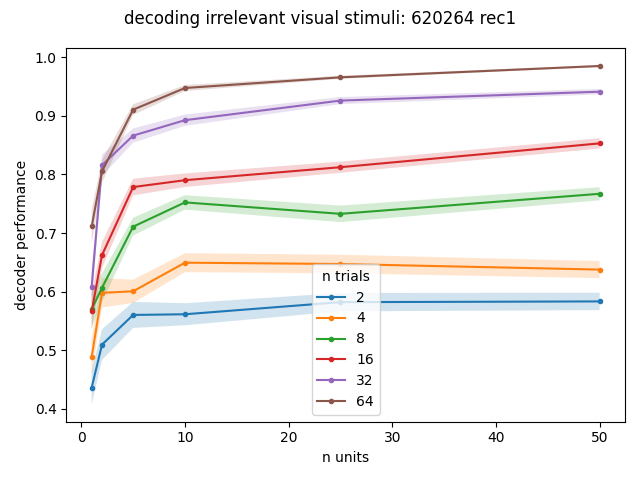

In [80]:
fig,ax=plt.subplots(1,1)

y1=decoder_acc_mean
err1=decoder_acc_sem
line1=ax.plot(n_units, y1,'.-')
for il,ll in enumerate(line1):
    plt.fill_between(n_units, y1[:,il]-err1[:,il], y1[:,il]+err1[:,il],
                    alpha=0.2, edgecolor=None, facecolor=ll.get_color())

ax.set_xlabel('n units')
ax.set_ylabel('decoder performance')
ax.legend(trial_number,title='n trials')

if modality[sel_session]=='aud':
    fig.suptitle('decoding irrelevant visual stimuli: '
                 +mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session]))
elif modality[sel_session]=='vis':
    fig.suptitle('decoding irrelevant auditory stimuli: '
                +mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session]))

fig.tight_layout()

<IPython.core.display.Javascript object>


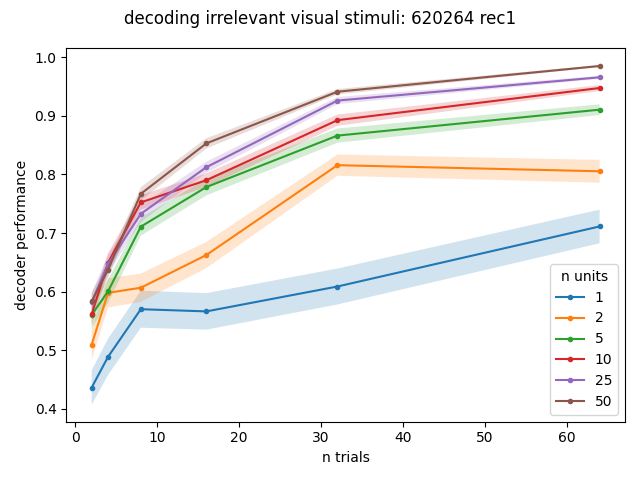

In [81]:
fig,ax=plt.subplots(1,1)
# ax.plot(trial_number,decoder_acc_mean.T,'o-')

y1=decoder_acc_mean.T
err1=decoder_acc_sem.T
line1=ax.plot(trial_number, y1,'.-')
for il,ll in enumerate(line1):
    plt.fill_between(trial_number, y1[:,il]-err1[:,il], y1[:,il]+err1[:,il],
                    alpha=0.2, edgecolor=None, facecolor=ll.get_color())

ax.set_xlabel('n trials')
ax.set_ylabel('decoder performance')
ax.legend(n_units,title='n units')

if modality[sel_session]=='aud':
    fig.suptitle('decoding irrelevant visual stimuli: '
                 +mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session]))
elif modality[sel_session]=='vis':
    fig.suptitle('decoding irrelevant auditory stimuli: '
                +mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session]))
    
fig.tight_layout()